# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [29]:
def load_data(data_dir='data'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    df = []

    for subject_id in [f"S{i}" for i in range(1, 10)]:

        subject_path = os.path.join(data_dir, subject_id)
            
        for session in ['midterm_1', 'midterm_2', 'Final']:
            session_path = os.path.join(subject_path, session)
            
            if not os.path.exists(session_path):
                continue
                
            hr_path = os.path.join(session_path, 'HR.csv')
            hr_df = pd.read_csv(hr_path, skiprows=2, header=None, names=['heart_rate'])
            start_time = pd.to_datetime(float(pd.read_csv(hr_path, nrows=1).columns[0]), unit='s')
            sample_rate = float(pd.read_csv(hr_path, skiprows=1, nrows=1).columns[0])
            timestamps = [start_time + pd.Timedelta(seconds=i/sample_rate) 
                            for i in range(len(hr_df))]
            hr_df['timestamp'] = timestamps
            
            eda_path = os.path.join(session_path, 'EDA.csv')            
            eda_df = pd.read_csv(eda_path, skiprows=2, header=None, names=['eda'])
            hr_df['eda'] = eda_df['eda']

            temp_path = os.path.join(session_path, 'TEMP.csv')
            temp_df = pd.read_csv(temp_path, skiprows=2, header=None, names=['temperature'])
            hr_df['temperature'] = temp_df['temperature']
        
            hr_df['subject_id'] = subject_id
            hr_df['session'] = session
            
            df.append(hr_df)
    
    if df:
        combined_df = pd.concat(df, ignore_index=True)
        return combined_df[['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']]
    return pd.DataFrame()

df = load_data()
df.to_csv('data/raw', index=False)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287292 entries, 0 to 287291
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   timestamp    287292 non-null  datetime64[ns]
 1   heart_rate   287292 non-null  float64       
 2   eda          287292 non-null  float64       
 3   temperature  287292 non-null  float64       
 4   subject_id   287292 non-null  object        
 5   session      287292 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 13.2+ MB


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [30]:
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Handle missing values
    # 2. Resample to regular intervals
    # 3. Remove outliers (z-score > 3)
    # 4. Save processed data to CSV files
    
    print(len(data))
    processed_data = []
    
    for subject in  data['subject_id'].unique():
        subject_data = data[data['subject_id'] == subject].copy()
        
        if subject_data.isnull().mean().max() > 0.01:
            print(f"Subject {subject} exceeds missing value threshold.")
            continue

        numeric_cols = ['heart_rate', 'eda', 'temperature']
        
        subject_data.dropna(subset=['timestamp'], inplace=True)
        subject_data.set_index('timestamp', inplace=True)
        numeric_data = subject_data[numeric_cols].resample('1s').mean()
        numeric_data.interpolate(method='linear', inplace=True)

        z_scores = np.abs(stats.zscore(subject_data[numeric_cols], nan_policy='omit'))
        mask = (z_scores < 3.5).all(axis=1)
        subject_data = subject_data[mask]
        
        subject_data.dropna(inplace=True)
        subject_data.reset_index(inplace=True)

        output_path = os.path.join(output_dir, f'{subject}_processed.csv')
        subject_data.to_csv(output_path, index=False)
        
        processed_data.append(subject_data)
    
    if processed_data:
        combined_df = pd.concat(processed_data, ignore_index=True)
        return combined_df
    
    return pd.DataFrame()

preprocessed_df = preprocess_data(df)
print(len(preprocessed_df))
preprocessed_df.head()


395278
391093


,timestamp,heart_rate,eda,temperature,subject_id,session
0,2018-10-13 12:56:16,84.00,0.000000,22.51,S1,midterm_1
1,2018-10-13 12:56:17,85.00,0.002563,22.51,S1,midterm_1
2,2018-10-13 12:56:18,86.00,0.019221,22.51,S1,midterm_1
3,2018-10-13 12:56:19,86.75,0.021784,22.51,S1,midterm_1
4,2018-10-13 12:56:20,87.40,0.023065,22.51,S1,midterm_1


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

['midterm_1' 'midterm_2' 'Final']


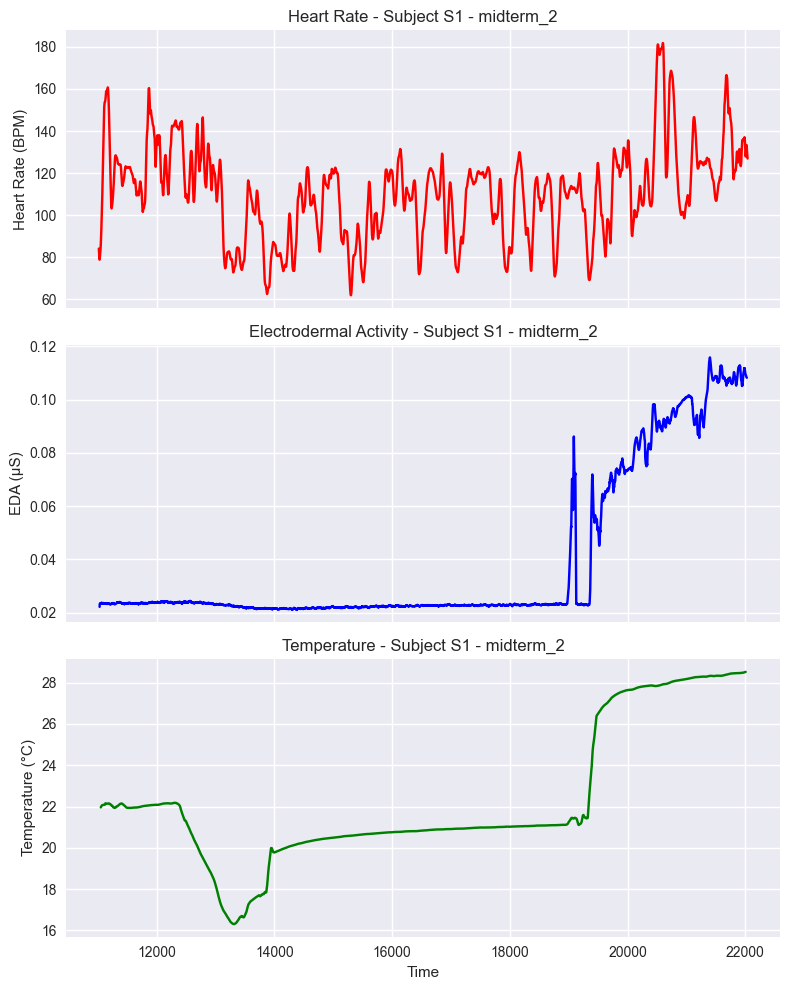

In [ ]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame 
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Create figure with subplots
    # 2. Plot each physiological signal
    # 3. Add labels and titles
    # 4. Save plot to file

    data = pd.read_csv(os.path.join(data, f"{subject_id}_processed.csv"))
    filtered_data = data[(data['subject_id'] == subject_id) & 
                        (data['session'] == session)].copy()
    
    fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    
    #HR
    axs[0].plot(filtered_data.index, filtered_data['heart_rate'].rolling(window=15, center=True).mean(), 'r-')
    axs[0].set_ylabel('Heart Rate (BPM)')
    axs[0].set_title(f'Heart Rate - Subject {subject_id} - {session}')
    axs[0].grid(True)
    
    #EDA
    axs[1].plot(filtered_data.index, filtered_data['eda'].rolling(window=40, center=True).mean(), 'b-')
    axs[1].set_ylabel('EDA (μS)')
    axs[1].set_title(f'Electrodermal Activity - Subject {subject_id} - {session}')
    axs[1].grid(True)
    
    #Temp
    axs[2].plot(filtered_data.index, filtered_data['temperature'].rolling(window=80, center=True).mean(), 'g-')
    axs[2].set_ylabel('Temperature (°C)')
    axs[2].set_title(f'Temperature - Subject {subject_id} - {session}')
    axs[2].set_xlabel('Time')
    axs[2].grid(True)
    
    plt.tight_layout()
    
    filename = f"{subject_id}_{session}_signals.png"
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    return fig

# fig = plot_physiological_signals('data/processed', 'S1', 'midterm_1')
fig = plot_physiological_signals('data/processed', 'S1', 'midterm_2')
# fig = plot_physiological_signals('data/processed', 'S1', 'Final')